In [1]:
import seaborn as sns
import imageio
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import nopdb
from tqdm.auto import tqdm
from scipy import ndimage
from scipy.special import softmax
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.plotting import plot_attention_cloud

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [13]:
img = Image.open('example_data/cube_stack.jpg')
torch.device('cuda') 
def sample_from_model():
    samples = None
    k = 0
    stored_x = None
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.forward) as x_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            break
    stored_x = x_call.args['x'][0]
    print(stored_x.shape)
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            if x.shape[2] == 1024:
                samples = x
                break 
            else:
                break
                           
    scale = 1 / math.sqrt(math.sqrt(attn_call.locals['attn_ch']))
    qkv = torch.nn.Linear(stored_x.shape[1], stored_x.shape[1]*3, device =torch.device('cuda'))
    torch.nn.init.normal_(qkv.weight, std=1)
    qkv_out = qkv(stored_x)
    qkv_out = qkv_out.view(1, 1281, 8, -1) 
    new_q, new_k,_ = torch.split(qkv_out, 64, dim=-1)
    attention_scores = torch.einsum("bihd, bjhd -> bhij", new_q*scale, new_k*scale)
    attention_probs = attention_scores.softmax(dim=-1)
    
    # Average across all heads
    avg_attn = torch.mean(attention_probs[0], dim = 0)
    
    # Est. self attention
    pc_self_attn = avg_attn[257:, 257:]
    
    # Est. cross attention
    pc_cross_attn = avg_attn[:257, 257:]

    pc_self_attn = pc_self_attn.cpu()
    pc_cross_attn = pc_cross_attn.detach().cpu()
    avg_attn = avg_attn.cpu()
    return pc_self_attn, pc_cross_attn, avg_attn, samples

0it [00:00, ?it/s]

torch.Size([1281, 512])


0it [00:00, ?it/s]

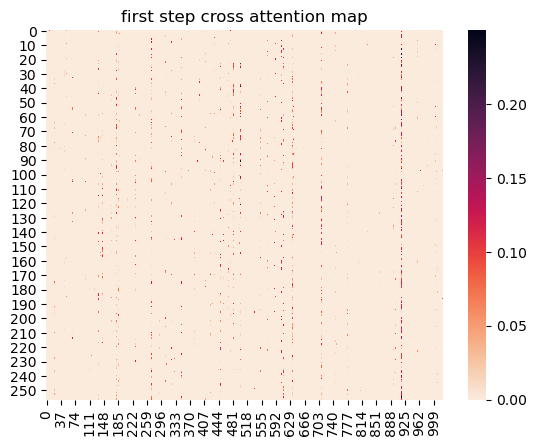

In [14]:
#Get the attention map of one iteration
_, cross_atn, attn, samples = sample_from_model()

ax = sns.heatmap(cross_atn, cmap = 'rocket_r')
plt.title('first step cross attention map')
plt.show()

In [7]:
# Load an image to condition on.
img = Image.open('example_data/cube_stack.jpg')

def sample_from_model(breakpoint):
    samples = None
    k = 0
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            if x.shape[2] == 1024:
                samples = x
                if k == breakpoint:
                    break
                k += 1
            else:
                break
    attention_scores = attn_call.locals['weight'][0]
    attention_probs = attention_scores.softmax(dim=-1)
    
    # Average across all heads
    avg_attn = torch.mean(attention_probs, dim = 0)
    
    # Est. self attention
    pc_self_attn = avg_attn[257:, 257:]
    
    # Est. cross attention
    pc_cross_attn = avg_attn[:257, 257:]

    pc_self_attn = pc_self_attn.cpu()
    pc_cross_attn = pc_cross_attn.cpu()
    avg_attn = avg_attn.cpu()
    return pc_self_attn, pc_cross_attn, avg_attn, samples

In [9]:
breakpoints = 0
time = [0, 1, 2, 3, 4, 5, 6, 7]

# Initial attention map

0it [00:00, ?it/s]

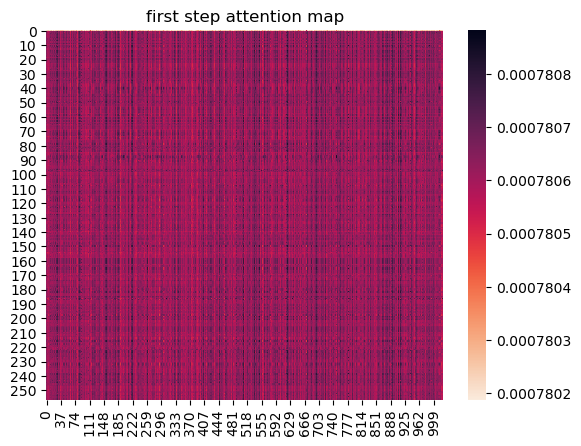

In [10]:
_, cross_atn, attn, samples = sample_from_model(breakpoints)
ax = sns.heatmap(cross_atn, cmap = 'rocket_r')
plt.title('first step attention map')
plt.show()


# Cross attention to conditioning image

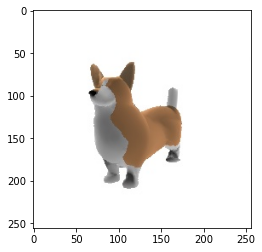

In [7]:
plt.imshow(img)

plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

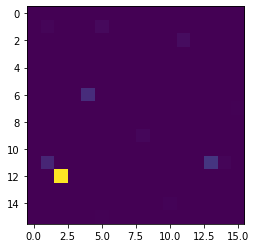

In [8]:
frames = []
raw_frames = []
import numpy as np
for k in breakpoints:
    _, cross_attn, _, samples = sample_from_model(k)
    c = softmax(np.mean(cross_attn.numpy(), axis= 0))
    c = c[1:257]
    c = c.reshape(16,16)
    fig = plt.imshow(c)
 
    plt.savefig('Figures/cross_Attn_gif/fig' + str(k) + '.png', bbox_inches='tight')

    
    image = Image.open('Figures/cross_Attn_gif/fig' + str(k) + '.png')
    
    # fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    # plt.savefig('Figures/cross_Attn_gif/fig' + str(k) + '.png', bbox_inches='tight')
    
    # image = imageio.v2.imread('Figures/cross_Attn_gif/fig' + str(k) + '.png')
    raw_frames.append(c)
    frames.append(image) 

In [11]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
 
path = "EDSR_x4.pb"
 
sr.readModel(path)
 
sr.setModel("edsr",4)
 
upsampled_frames = []
for i,img in enumerate(raw_frames):
    print(img.shape)
    result = sr.upsample(img)
    fig = plt.imshow(result)
    plt.savefig('Figures/cross_Attn_gif/up_fig' + str(i) + '.png', bbox_inches='tight')
    image = Image.open('Figures/cross_Attn_gif/up_fig' + str(i) + '.png')
    upsampled_frames.append(image)


imageio.mimsave('Figures/cross_Attn_gif/cross_attn_Diffusion.gif', # output gif
                upsampled_frames,          # array of input frames
                duration = 250)  

(16, 16)


error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/layers/convolution_layer.cpp:419: error: (-2:Unspecified error) Number of input channels should be multiple of 3 but got 1 in function 'getMemoryShapes'


: 

# Average attention all points.

In [ ]:
frames = []
import numpy as np
for k in breakpoints:
    self_attn, _, _, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = softmax(np.mean(self_attn.numpy(), axis= 0))
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    plt.savefig('Figures/avg_Attn_gif/fig' + str(k) + '.png', bbox_inches='tight')
    
    image = imageio.v2.imread('Figures/avg_Attn_gif/fig' + str(k) + '.png')
    frames.append(image) 

In [8]:
imageio.mimsave('Figures/avg_Attn_gif/avg_attn_Diffusion.gif', # output gif
                frames,          # array of input frames
                duration = 250)   

: 

# Code to plot colored attention clouds 

0it [00:00, ?it/s]

<class 'numpy.ndarray'>


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Diffusion_gif/fig0.png'

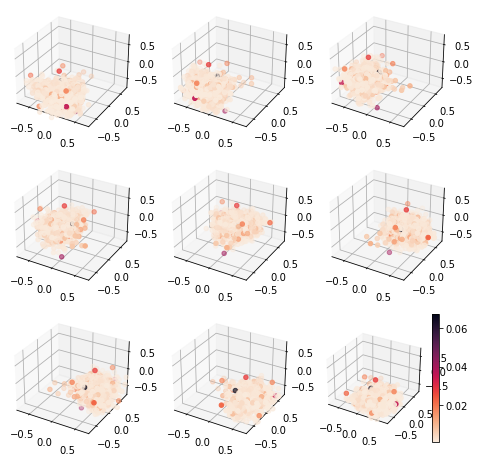

: 

In [15]:
frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.diagonal(pc_self_attn)
    print(type(c))
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    plt.savefig('Figures/Diffusion_gif/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Diffusion_gif/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Diffusion_gif/Diffusion.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

In [9]:
    
imageio.mimsave('Figures/Diffusion_gif/Diffusion.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second